In [1]:
!pip install konlpy

In [2]:
import os
import pandas as pd
from collections import Counter
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')

fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13
current_dir = os.getcwd()
csv_dir = os.path.join(current_dir, 'data', 'raw_csv')
train_csv_path = os.path.join(csv_dir, 'merged_train.csv')

/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13


In [5]:
df = pd.read_csv(train_csv_path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4637 entries, 0 to 4636
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4637 non-null   int64 
 1   class         4637 non-null   object
 2   conversation  4637 non-null   object
dtypes: int64(1), object(2)
memory usage: 108.8+ KB


,idx,class,conversation
0,1951,직장 내 괴롭힘 대화,팀장님 이거 언제까지 마무리 하면 될까요?\n무리하지 말고 넉넉하게 주말까지 다 작...
1,4756,일반 대화,"내일 날씨 어떻대?\n비 온다던데. 우산 챙겨가야 할 것 같아.\n에이, 야외 활동..."
2,1234,기타 괴롭힘 대화,야 쟤 좀 봐.\n 꼴에 유행하는 옷 입었네 \n 호박에 줄 긋는다고 수박되나 \n...
3,4767,일반 대화,오늘 수업 내용 이해했어?\n솔직히 좀 어려웠어. 너는?\n나도 몇 부분이 헷갈리더...
4,1511,직장 내 괴롭힘 대화,자네 내일 아침에 우리집 들려서 출근하게\n네?\n내가 차가 고장났어\n아. 그런데...


In [6]:
okt = Okt()

# 전처리 함수
def preprocess(text):
    return text.replace('\n', ' ').replace('\t', ' ').strip()

# 품사 태깅
def pos_tagging(text):
    # 관형사, 감탄사, 조사, 어미 등은 불용어 대상으로 토큰화 과정에 제외
    # 부사는 우리의 task에 중요한 정보라 판단하여 포함("진짜 짜증나", "너 정말 못됐다")
    return [word for word, pos in okt.pos(text) if pos in ['Noun', 'Verb', 'Adjective', 'Adverb']]

## 단어 분포 확인

In [7]:
# 전체 품사별 빈도수 계산
all_tokens = []
for conv in df['conversation']:
    tokens = pos_tagging(preprocess(conv))
    all_tokens.extend(tokens)

all_freq = Counter(all_tokens).most_common(30)
print("전체 상위 단어")
print(all_freq)

# 클래스별 빈도 계산
class_freqs = {}
for label in df['class'].unique():
    class_tokens = []
    sub_df = df[df['class'] == label]
    for conv in sub_df['conversation']:
        tokens = pos_tagging(preprocess(conv))
        class_tokens.extend(tokens)
    class_freqs[label] = Counter(class_tokens).most_common(20)

for cls, freq in class_freqs.items():
    print(f"\n [{cls}] 상위 단어:")
    print(freq)

전체 상위 단어
[('너', 4633), ('내', 3929), ('나', 2753), ('네', 2707), ('말', 2648), ('왜', 2510), ('뭐', 2389), ('거', 2268), ('좀', 2073), ('돈', 1939), ('해', 1753), ('다', 1752), ('있어', 1583), ('이', 1518), ('것', 1515), ('진짜', 1475), ('저', 1452), ('죄송합니다', 1428), ('니', 1411), ('지금', 1409), ('아니', 1375), ('제', 1282), ('그럼', 1253), ('그래', 1224), ('오늘', 1157), ('우리', 1118), ('안', 1111), ('생각', 1094), ('할', 1051), ('요즘', 1043)]

 [직장 내 괴롭힘 대화] 상위 단어:
[('네', 1163), ('죄송합니다', 872), ('내', 702), ('좀', 595), ('말', 579), ('너', 542), ('일', 540), ('제', 531), ('저', 521), ('거', 483), ('뭐', 483), ('왜', 478), ('대리', 454), ('회사', 447), ('해', 419), ('다', 413), ('아니', 409), ('지금', 375), ('것', 370), ('오늘', 344)]

 [일반 대화] 상위 단어:
[('있어', 1100), ('요즘', 821), ('뭐', 623), ('것', 502), ('생각', 467), ('정말', 412), ('같아', 407), ('어떻게', 396), ('오늘', 380), ('좋은', 378), ('이번', 353), ('주말', 351), ('해', 340), ('응', 338), ('수', 333), ('영화', 309), ('나도', 304), ('잘', 281), ('어떤', 277), ('어때', 273)]

 [기타 괴롭힘 대화] 상위 단어:
[('너', 1481), ('왜

*전체 상위 단어*
- 너, 내, 나, 네, 우리와 같은 인칭 대명사가 많음
- 이 단어들은 대부분의 클래스에서 공통적으로 많이 등장하며 명확한 구분 정보 없이 자주 쓰이는 표현임
- 몇몇 단어 들은 **불용어 처리**를 고려할 수 있음

*협박 단어*
- 제발, 해, 지금, 진짜, 사람
- “제발 그만해”, “사람 죽이기 전에” 등 감정 호소나 협박 표현이 포함될 수 있음
- 해당 단어들에 높은 가중치를 고려할 수 있음

*일반 대화*
- 요즘, 계획, 영화, 응, 주말, 좋은
- 일상적인 표현이 많이 들어가있음
- 훈련데이터에 없던 합성 데이터인 만큼 **과적합** 우려가 있는 단어

*갈취 대화*
- 돈, 좀, 진짜, 그럼
- "돈 좀 빌려줘" 등 갈취 상황에 쓰이는 표현이 될 수 있음
- 해당 단어들에 높은 **가중치**를 고려할 수 있음

*기타 괴롭힘 대화*
- 다른 클래스에서 사용하는 여러 표현들이 모두 포함돼있음
- 다른 클래스와 구분이 어려울 가능성이 높음
- 주요 특징을 기준으로 **데이터 증강** 등을 통해 충분한 데이터 확보 필요

*직장 내 괴롭힘 대화*
- 죄송합니다, 대리, 회사, 일, 제
- 직급명이나 사과 표현 직장에서 자주 사용하는 표현임
- 해당 단어들에 높은 가중치를 고려할 수 있음
- 다른 클래스에 비해 구분을 잘 할 가능성이 높음


*정리*
- 일반 대화
  - 일상적인 단어가 충분해 다른 클래스와 구분을 잘 하겠지만 합성 데이터이므로 과적합 가능성이 높음

- 갈취 대화
  - "돈"이라는 키워드를 주의깊게 봐야하며 다른 클래스와 구분을 잘 할 가능성이 높음

- 직장 내 괴롭힘 대화
  - 직장에서 사용하는 표현이 자주 있어 다른 클래스와 구분을 잘 할 가능성이 높음

- 협박 대화와 기타 괴롭힘 대화
  - 다른 클래스에서 두루쓰는 표현들이 많아 구분이 어려울 수 있음
  - 데이터 증강이나 주요 표현을 잘 추출하는 방법이 필요

## TF-IDF로 특징적인 단어 추출
+ 문서의 TF-IDF 점수를 클래스 별로 합산하여 클래스별 TF-IDF를 추출

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
import matplotlib.pyplot as plt

df['tokenized'] = df['conversation'].apply(lambda x: ' '.join(pos_tagging(preprocess(x))))

In [9]:
# TF-IDF 벡터화기 생성
vectorizer = TfidfVectorizer(max_features=5000)

# 전체 데이터셋에 대해 vocabulary 생성
vectorizer.fit(df['tokenized'])

# 클래스별로 TF-IDF 계산
class_tfidf = {}

for label in df['class'].unique():
    sub_df = df[df['class'] == label]

    # 해당 클래스의 데이터만 transform
    tfidf_matrix = vectorizer.transform(sub_df['tokenized'])

    # 각 단어의 TF-IDF 점수 추출
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # TF-IDF 점수가 높은 단어 추출
    sorted_indices = tfidf_scores.argsort()[::-1]
    sorted_words = [feature_names[i] for i in sorted_indices]
    sorted_scores = tfidf_scores[sorted_indices]

    # 클래스별 특징적인 단어 추출
    class_tfidf[label] = list(zip(sorted_words[:20], sorted_scores[:20]))

In [10]:
for cls, top_words in class_tfidf.items():
    print(f"[{cls}]", end=" ")
    for word, score in top_words:
        print(f"{word}: {score:.2f}", end="  ")
    print("\n")

[직장 내 괴롭힘 대화] 죄송합니다: 71.76  대리: 47.59  회사: 37.72  부장: 34.42  아니: 27.41  과장: 27.05  자네: 25.66  아닙니다: 25.48  오늘: 25.20  지금: 24.93  하겠습니다: 22.68  업무: 21.00  휴가: 20.00  알겠습니다: 19.73  사람: 19.61  그럼: 18.38  말씀: 18.28  무슨: 16.89  하는: 16.82  우리: 16.82  

[일반 대화] 있어: 61.70  요즘: 53.06  같아: 31.57  정말: 31.45  영화: 29.71  주말: 29.64  어떤: 29.52  생각: 27.77  좋은: 27.47  좋아: 27.02  계획: 26.09  오늘: 25.83  어때: 24.87  이번: 24.38  고마워: 24.10  어떻게: 23.41  했어: 21.35  나도: 21.09  같이: 20.31  준비: 18.99  

[기타 괴롭힘 대화] 진짜: 32.35  아니: 26.42  그래: 25.17  그냥: 23.90  우리: 22.51  아니야: 21.17  고객: 20.23  냄새: 19.59  새끼: 19.48  그만해: 19.43  그렇게: 19.25  너무: 17.66  손님: 17.52  여기: 17.40  무슨: 17.25  엄마: 17.18  죄송합니다: 16.63  얼굴: 16.54  지금: 16.43  사람: 16.23  

[협박 대화] 제발: 39.03  죽여: 29.57  지금: 26.81  진짜: 23.81  우리: 22.66  사람: 22.07  죄송합니다: 20.64  그래: 19.61  살려주세요: 19.21  가족: 18.88  새끼: 18.83  그냥: 18.58  하면: 18.56  당신: 17.24  신고: 16.97  하나: 16.02  소리: 15.71  당장: 15.67  어떻게: 15.39  정말: 15.38  

[갈취 대화] 내놔: 36.57  진짜: 35.43  없어요: 29.55  없어

- 갈취 대화 키워드
  - 내놔, 진짜, 없어요, 없어, 그럼
  -  갈취에서 돈의 경우 한글자 단어라 자동으로 제외됐는데, 한글자까지 포함했을 때 93.5188로 매우 높았음

- 직장 내 괴롭힘 대화 키워드
  - 죄송합니다, 대리, 회사, 부장, 과장, 자네

**협박 대화와 기타 괴롭힘 대화**

이 둘을 잘 구분하는 것이 중요해보입니다. 토큰으로 명확하게 구분할만한 표현은 찾지 못했습니다.

## 워드 클라우드

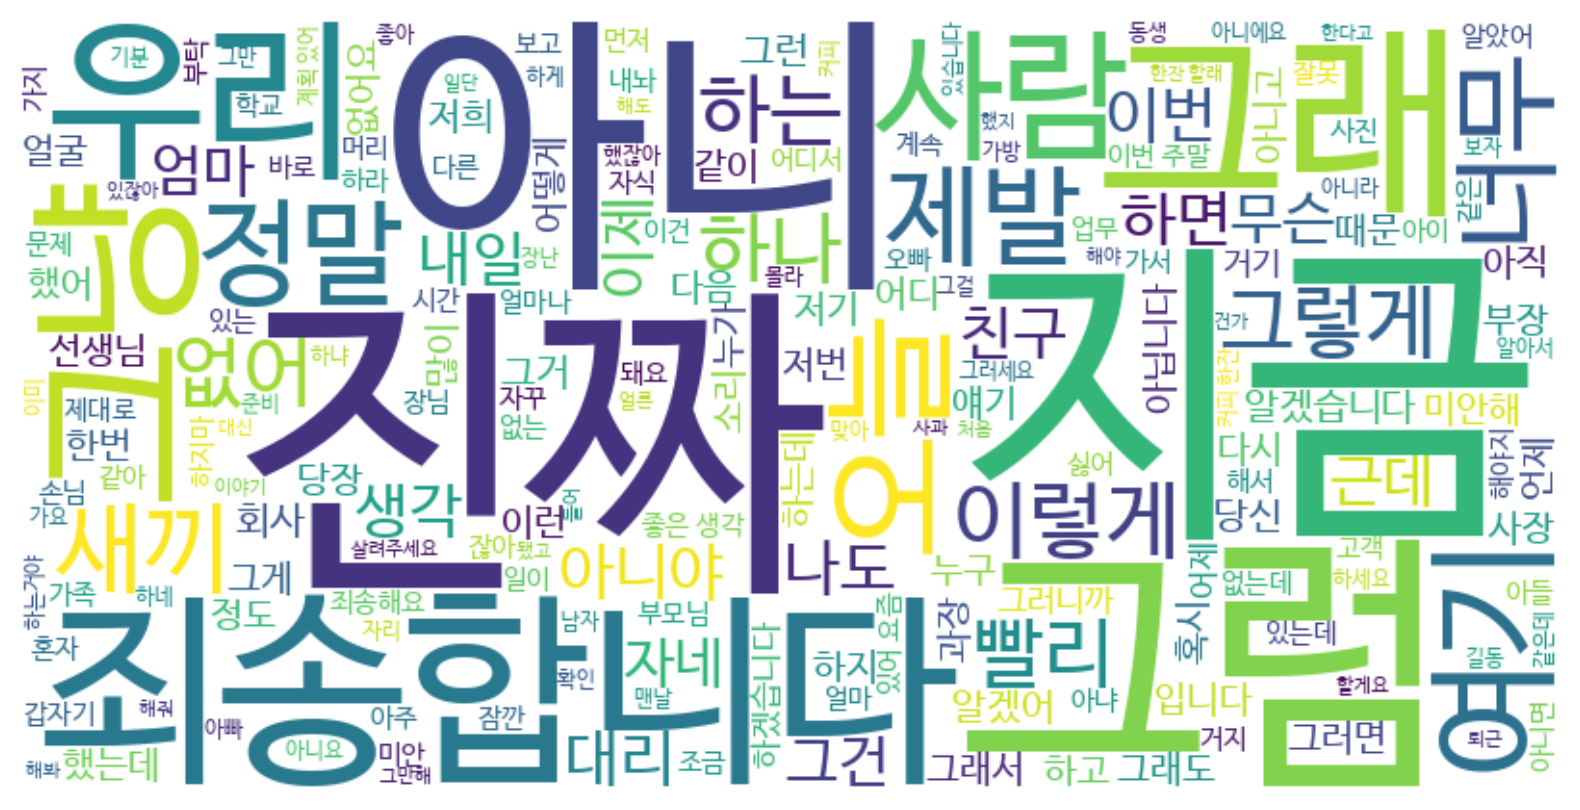

In [22]:
# 전체 데이터에서 두 글자 이상인 모든 단어를 하나의 문자열로 결합
all_text = " ".join(df['tokenized'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1])))

wordcloud = WordCloud(font_path = fontpath, width=800, height=400, background_color='white').generate(all_text)

# 생성된 워드 클라우드 출력
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
# 클래스별 워드 클라우드 생성
classes = df['class'].unique()

for cls in classes:
    class_data = df[df['class'] == cls]
    class_text = " ".join(class_data['tokenized'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1])))

    # 워드 클라우드 생성
    wordcloud = WordCloud(font_path = fontpath, width=800, height=400, background_color='white').generate(class_text)

    print(f"클래스 - {cls}:")
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.